# MVRegFus: Stitching

Notebook to test stitching / tiling of many tif stacks.

- Create test data
- Write to tifs
- Run registration and fusion

In [1]:
%matplotlib inline
import mvregfus
from mvregfus import multiview

import numpy as np
from scipy import ndimage
from dask import array as da
import tifffile

In [2]:
# create large contiguous field of view from random data

xy_shape = 500
im1 = np.random.random((5, 50, 50)) # high frequency
im2 = np.random.random((1, 10, 10)) # low frequency
im = ndimage.zoom(im1, int(xy_shape / im1.shape[1]), order=3) *\
     ndimage.zoom(im2, int(xy_shape / im2.shape[1]), order=3)
im = (np.clip(im, 0, 1) * 10000).astype(np.uint16)

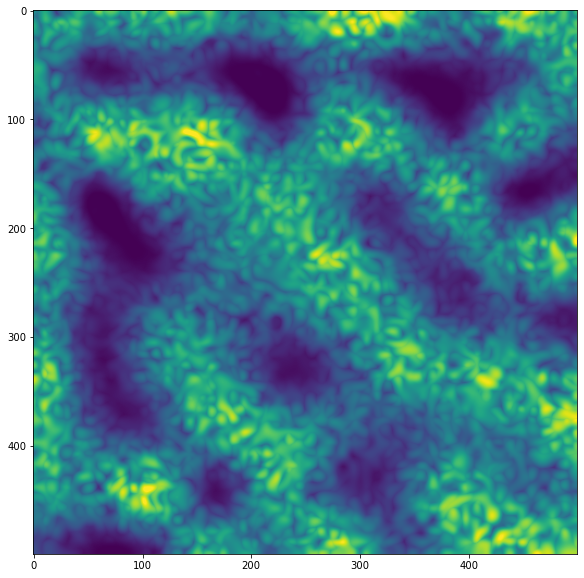

In [3]:
import matplotlib.pylab as plt
plt.figure(figsize=(10,10))
plt.imshow(im.max(-3), vmin=0, vmax=10000)

In [4]:
# divide fov into tiles

n_tiles_per_dim = 5
px_overlap_between_stacks = 20
max_misalignment = 5 # in px

chunksize = int(im.shape[1] / n_tiles_per_dim)
nchunks = da.core.normalize_chunks([im.shape[0]] + [chunksize]*2, im.shape)

x = da.from_array(im, chunks=[im.shape[0], chunksize, chunksize])

# create overlap between tiles
x = da.overlap.overlap(x, {i: px_overlap_between_stacks+max_misalignment for i in [1, 2]}, boundary=0)

# randomly displace each tile 
x = x.map_blocks(lambda b: ndimage.affine_transform(
        b, matrix=np.eye(3),
        offset=(np.random.random(3) - 0.5) * max_misalignment * 2),
    dtype=x.dtype)

# trim part of the overlap
x = da.overlap.trim_overlap(x, {i: max_misalignment + 1 for i in [1, 2]})

# add some shot noise
x = x.map_blocks(lambda b: b + np.random.randint(0, 100, b.shape).astype(np.uint16))

x

dask.array<lambda, shape=(50, 690, 690), dtype=uint16, chunksize=(50, 138, 138), chunktype=numpy.ndarray>

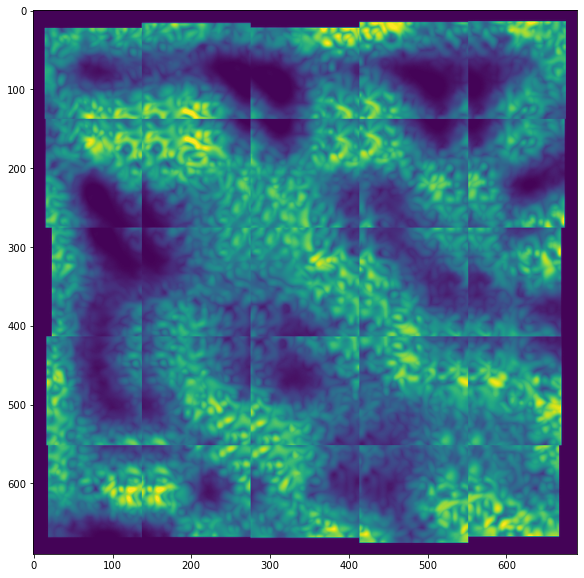

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(x.max(-3), vmin=0, vmax=10000)

In [6]:
# %matplotlib notebook
# tifffile.imshow(x.max(-3), vmin=0, vmax=10000)

In [7]:
# save data into tifs
import os; os.makedirs('data/stitch', exist_ok=True)
for ind in np.ndindex(x.numblocks):
    tifffile.imsave('data/stitch/stack_tile_%s_%s.tif' %(ind[-2], ind[-1]), x.blocks[ind])

In [8]:
ls data/stitch/

mv_params_000_000_vfix000_vmov001.prealignment.h5
mv_params_000_000_vfix000_vmov005.prealignment.h5
mv_params_000_000_vfix002_vmov003.prealignment.h5
mv_params_000_000_vfix002_vmov007.prealignment.h5
mv_params_000_000_vfix003_vmov004.prealignment.h5
mv_params_000_000_vfix003_vmov008.prealignment.h5
mv_params_000_000_vfix004_vmov003.prealignment.h5
mv_params_000_000_vfix006_vmov007.prealignment.h5
stack_tile_0_0.tif
stack_tile_0_1.tif
stack_tile_0_2.tif
stack_tile_0_3.tif
stack_tile_0_4.tif
stack_tile_1_0.tif
stack_tile_1_1.tif
stack_tile_1_2.tif
stack_tile_1_3.tif
stack_tile_1_4.tif
stack_tile_2_0.tif
stack_tile_2_1.tif
stack_tile_2_2.tif
stack_tile_2_3.tif
stack_tile_2_4.tif
stack_tile_3_0.tif
stack_tile_3_1.tif
stack_tile_3_2.tif
stack_tile_3_3.tif
stack_tile_3_4.tif
stack_tile_4_0.tif
stack_tile_4_1.tif
stack_tile_4_2.tif
stack_tile_4_3.tif
stack_tile_4_4.tif


In [12]:
from mvregfus import mv_graph, io_utils, mv_utils

import importlib
mv_graph = importlib.reload(mv_graph)
io_utils = importlib.reload(io_utils)
mv_utils = importlib.reload(mv_utils)
multiview = importlib.reload(multiview)

# specify input views
view_dict = dict()
for iind, ind in enumerate(np.ndindex(x.numblocks)):
    view_dict[iind] = dict()
    view_dict[iind]['view'] = iind # view identifier
    view_dict[iind]['filename'] = 'data/stitch/stack_tile_%s_%s.tif' %(ind[-2], ind[-1])
    view_dict[iind]['spacing'] = np.ones(3)
    view_dict[iind]['rotation'] = 0 # all tiles have same rotation angle
    view_dict[iind]['shape'] = x.blocks[ind].shape
    view_dict[iind]['origin'] = np.array(ind) * np.array([0] + 2*[xy_shape / n_tiles_per_dim]) - px_overlap_between_stacks

# specify pairwise registrations (all grid neighbors, i.e. if exactly one grid index changes)
pairs = [(ii,ij) for ii, i in enumerate(np.ndindex(x.numblocks))
 for ij, j in enumerate(np.ndindex(x.numblocks))
 if np.sum(np.abs(np.array(i)-np.array(j))) == 1]
# pairs = pairs[:1]

# build dask graph
graph = mvregfus.mv_graph.build_multiview_graph(
    out_dir='data/stitch',
    filepath=None,
    channels=[0],
    mv_registration_bin_factors=[1,1,1],
    mv_final_spacing=[1,1,1],
    pairs=pairs,
    view_dict=view_dict,
    fusion_method='weighted_average',
    fusion_weights='blending',
#     fusion_weights='dct',
    elastix_dir='/Users/marvin/Documents/projects/elastix',
    pairwise_registration_mode=0, # 0: translation registration using elastix
    final_volume_mode='union',
    debug_pairwise_registration=False,
)

# compute dask graph
o = io_utils.get(graph, mv_graph.multiview_fused_label %(0, 0, 0), local=False)

bokeh.server.util - WARNING - Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly


In [10]:
# load result from file
fused_result = io_utils.process_input_element(os.path.join('data/stitch', mv_graph.multiview_fused_label %(0, 0, 0)))

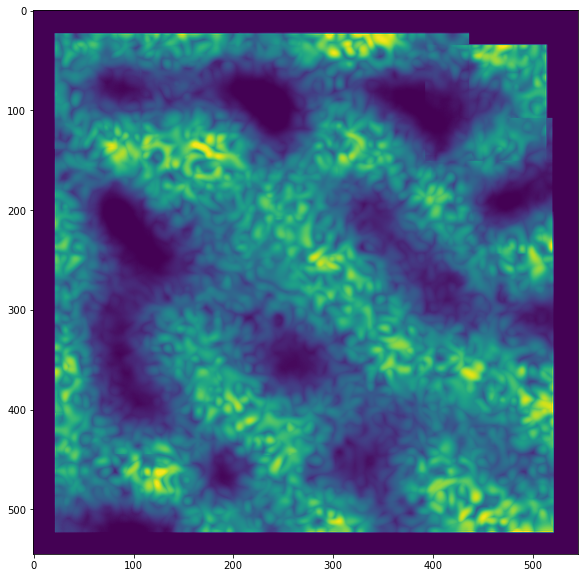

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(fused_result.max(-3), vmin=0, vmax=10000)
